In [1]:
import numpy as np
import pandas as pd
import os, io, random
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import tensorflow as tf
import tensorflow.keras as k
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Using memory growth regime.")
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass


Num GPUs Available:  1
Using memory growth regime.


2023-05-06 01:22:02.056405: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-06 01:22:02.076276: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-06 01:22:02.076444: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


#### Step 1: Creating the gridworld.

In [2]:
# Vector shape per cell = 32:
"""
1 -> R
2 -> G
3 -> B
4 -> Alpha (dead or alive)
5 - 32 -> hidden variables of the cell.
"""

# Image resolution = 256 * 256
# Center the image and put it in the middle of the grid, with active pixels taking up roughly 1/2 of the space (128 * 128)
# Map shape = (256, 256, 32)

HYPERPARAMS = {'min-steps': 0,
               'max-steps': 0,
               'min-backprop-steps': 64,
               'max-backprop-steps': 96,
               'map_width': 48,
               'map_height': 48,
              'cell_vars': 16,
              'kernel_size':(3,3),
              'alive_threshold':0.1}
from tensorflow.keras import layers, optimizers, models
in_ = layers.Input((*HYPERPARAMS['kernel_size'], HYPERPARAMS['cell_vars']))
x = layers.Conv2D(HYPERPARAMS['cell_vars'], kernel_size = HYPERPARAMS['kernel_size'], padding = "valid", activation="relu")(in_)
x = layers.Reshape((1, HYPERPARAMS['cell_vars']))(x)

def layer(x, n=5):
    x = layers.Conv1D(32, kernel_size = n, padding = "same", activation='relu')(x)
    return x
x = layer(x, 5)
x = layer(x, 3) 
x = layers.Flatten()(x)
x = layers.Dense(HYPERPARAMS["cell_vars"], kernel_initializer="zeros",bias_initializer="zeros")(x)
update_model = models.Model(in_, x)
update_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 3, 16)]        0         
                                                                 
 conv2d (Conv2D)             (None, 1, 1, 16)          2320      
                                                                 
 reshape (Reshape)           (None, 1, 16)             0         
                                                                 
 conv1d (Conv1D)             (None, 1, 32)             2592      
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 32)             3104      
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 16)                528   

2023-05-06 01:22:04.035753: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-06 01:22:04.037694: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-06 01:22:04.037942: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-06 01:22:04.038149: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [3]:
import random

def clip(x, min_=0, max_=255):
    if x > max_: return max_
    if x < min_: return min_
    else: return x

def update_grid(grid, update_p = 0.5, fire_rate = 0.5):
    
    patches = tf.image.extract_patches(
    tf.reshape(grid, (1, HYPERPARAMS['map_height'], HYPERPARAMS['map_width'], HYPERPARAMS['cell_vars'])), (1,*HYPERPARAMS['kernel_size'],1), (1,1,1,1), (1,1,1,1), padding='SAME')
    input_batch = tf.reshape(patches, (HYPERPARAMS['map_height'],HYPERPARAMS['map_width'], *HYPERPARAMS['kernel_size'], HYPERPARAMS['cell_vars']))
    input_batch = tf.reshape(input_batch, (HYPERPARAMS['map_height']*HYPERPARAMS['map_width'], *HYPERPARAMS['kernel_size'], HYPERPARAMS['cell_vars']))

    alive_mask = tf.math.reduce_max(tf.reshape(input_batch, (HYPERPARAMS['map_height'],HYPERPARAMS['map_width'],HYPERPARAMS['kernel_size'][0] * HYPERPARAMS['kernel_size'][1],HYPERPARAMS['cell_vars']))[:,:,:,3], axis=2) > HYPERPARAMS['alive_threshold']
    alive_mask = tf.cast(tf.reshape(alive_mask, (HYPERPARAMS['map_height'], HYPERPARAMS['map_width'], 1)), tf.float32)
    #mask = tf.random.categorical(tf.math.log([[0.5, 0.5]]), HYPERPARAMS['map_height']*HYPERPARAMS['map_width'])
    mask = tf.random.uniform((HYPERPARAMS['map_height'], HYPERPARAMS['map_width'], 1)) <= fire_rate
    mask = tf.cast(mask, tf.float32)
    
    update_batch = update_model(input_batch)
    update_batch = tf.reshape(update_batch, (HYPERPARAMS['map_height'], HYPERPARAMS['map_width'], HYPERPARAMS['cell_vars']))
    #mask = tf.Tensor(np.random.choice(2, (256, 256, 1)))
    # samples has shape [1, 5], where each value is either 0 or 1 with equal
# probability.
    update_batch = update_batch * alive_mask * mask
    return update_batch

In [4]:
#!wget https://www.druva.com/content/dam/druvaincprogram/blog/thumbnails/blog-understanding-neural-networks-through-visualization-post.jpg
#!mv blog-understanding-neural-networks-through-visualization-post.jpg target.jpg

--2023-05-02 01:26:41--  https://www.druva.com/content/dam/druvaincprogram/blog/thumbnails/blog-understanding-neural-networks-through-visualization-post.jpg
Resolving www.druva.com (www.druva.com)... 146.75.95.10
Connecting to www.druva.com (www.druva.com)|146.75.95.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 370042 (361K) [image/jpeg]
Saving to: ‘blog-understanding-neural-networks-through-visualization-post.jpg’

blog-understanding- 100%[===================>] 361.37K  1.15MB/s    in 0.3s    

2023-05-02 01:26:41 (1.15 MB/s) - ‘blog-understanding-neural-networks-through-visualization-post.jpg’ saved [370042/370042]



In [9]:
!wget https://raw.githubusercontent.com/googlefonts/noto-emoji/main/png/32/emoji_u1f5ff.png

--2023-05-02 04:25:38--  https://raw.githubusercontent.com/googlefonts/noto-emoji/main/png/32/emoji_u1f5ff.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1282 (1.3K) [image/png]
Saving to: ‘emoji_u1f5ff.png’

emoji_u1f5ff.png    100%[===================>]   1.25K  --.-KB/s    in 0s      

2023-05-02 04:25:38 (81.5 MB/s) - ‘emoji_u1f5ff.png’ saved [1282/1282]



In [10]:
!mv emoji_u1f5ff.png target.jpg

In [4]:
grid = np.zeros((HYPERPARAMS['map_height'], HYPERPARAMS['map_width'], HYPERPARAMS['cell_vars']))
grid[HYPERPARAMS['map_height']//2][HYPERPARAMS['map_width']//2] += 1 # Alive cell in the middle of the image
grid = tf.convert_to_tensor(grid, dtype=tf.float32)
with tf.GradientTape() as tape:
    update_batch = update_grid(grid)
grads = tape.gradient(update_batch, update_model.trainable_variables)
grads[-1] # Check that the gradients are being calculated properly

2023-05-06 01:22:10.837364: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-06 01:22:10.932498: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2023-05-06 01:22:11.686766: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-06 01:22:11.687382: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-06 01:22:11.687401: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-05-06 01:22:11.688169: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-06 01:22:11.688226: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to

<tf.Tensor: shape=(16,), dtype=float32, numpy=
array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
      dtype=float32)>

/opt/conda/lib/python3.10/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Image shape: (48, 48, 4)


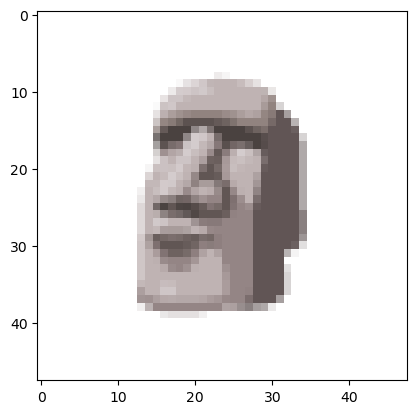

In [5]:
def loss(pred, true):
    return tf.reduce_mean(tf.square(true-pred))
lr = 2e-3
optimizer = k.optimizers.Adam(lr=lr)

from skimage import io
from skimage import transform
import matplotlib.pyplot as plt

cropped = io.imread("target.jpg") / 255.0
cropped = np.pad(cropped, ((8, 8), (8, 8), (0,0)), mode='constant')
plt.imshow(cropped)
print("Image shape:", cropped.shape)
cropped = tf.convert_to_tensor(cropped, dtype=tf.float32)
#cropped = tf.concat((cropped, tf.ones((HYPERPARAMS['map_height'], HYPERPARAMS['map_width'], 1))), axis=2)

### Training

#### Phase 1:

In [6]:
from tqdm import tqdm, trange
from collections import defaultdict

EPOCHS = 201
history = []
SAMPLE_EVERY = 100

with trange(EPOCHS) as pbar:
    for epoch in pbar:
        grid = np.zeros((HYPERPARAMS['map_height'], HYPERPARAMS['map_width'], HYPERPARAMS['cell_vars']))
        grid[HYPERPARAMS['map_height']//2][HYPERPARAMS['map_width']//2][3:] += 1 # Alive cell in the middle of the image
        grid = tf.convert_to_tensor(grid, dtype=tf.float32)

        if epoch % SAMPLE_EVERY == 0: history.append([grid[:, :, :3].numpy()])
        n_backprop_steps = random.randint(HYPERPARAMS['min-backprop-steps'],HYPERPARAMS['max-backprop-steps'])
        n_steps = random.randint(HYPERPARAMS['min-steps'], HYPERPARAMS['max-steps'])
        for ep in range(max(0, n_steps - n_backprop_steps)):
            grid += update_grid(grid)
            #grid = tf.clip_by_value(grid, 0, 1)
            if epoch % SAMPLE_EVERY == 0: history[-1].append(grid[:, :, :4].numpy())
        with tf.GradientTape() as grad:
            grad.watch(grid); grad.watch(update_model.trainable_variables)
            for ep in range(n_backprop_steps):
                update_batch = update_grid(grid)
                grid = grid + update_batch
                #grid = tf.clip_by_value(grid, 0, 1)
                if epoch % SAMPLE_EVERY == 0: history[-1].append(grid[:, :, :4].numpy())

            # dGdP = [tf.reduce_sum(tf.stack(grads_per_step[key]), axis=1) for key in grads_per_step]
            grad.watch(cropped)
            L = loss(grid[:, :, :4], cropped)
        dLdP = grad.gradient(L, update_model.trainable_variables)
        """
            with tf.GradientTape() as grad:
                grad.watch(grid); grad.watch(cropped)
                L = loss(grid[:,:,:3], cropped)
            dLdG = grad.gradient(L, grid)
        """
        normed_grads = [g/(tf.norm(g)+1e-8) for g in dLdP]
        optimizer.apply_gradients(zip(normed_grads, update_model.trainable_weights))
        
        pbar.set_description("Loss: {0:.5f}".format(L.numpy()), refresh = True)

Loss: 0.05354: 100%|████████████████████████████████████████████████████████| 201/201 [01:56<00:00,  1.73it/s]


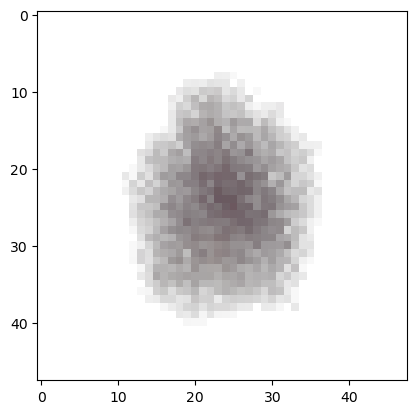

In [7]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Video

def generate_animation(episode):
    fig = plt.figure()

    # ims is a list of lists, each row is a list of artists to draw in the
    # current frame; here we are just animating one artist, the image, in
    # each frame
    ims = []
    for slice_ in episode:
        im = plt.imshow(tf.clip_by_value(slice_, 0, 1), animated=True, vmin=0, vmax=1)
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                    repeat_delay=1000)
    ani.save('dynamic_images.mp4')
generate_animation(history[-1])
Video(filename="dynamic_images.mp4")

In [8]:
update_model.save('./weights/phase1_run4')

INFO:tensorflow:Assets written to: ./weights/phase1_run4/assets


2023-05-06 01:24:16.513183: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


#### Phase 2:

In [9]:
config = optimizer.get_config()
config["learning_rate"] = 2e-4
optimizer = optimizer.from_config(config, custom_objects=None)

In [10]:
from tqdm import tqdm, trange
from collections import defaultdict

EPOCHS = 2001
SAMPLE_EVERY = 100

with trange(EPOCHS) as pbar:
    for epoch in pbar:
        grid = np.zeros((HYPERPARAMS['map_height'], HYPERPARAMS['map_width'], HYPERPARAMS['cell_vars']))
        grid[HYPERPARAMS['map_height']//2][HYPERPARAMS['map_width']//2] += 1 # Alive cell in the middle of the image
        grid = tf.convert_to_tensor(grid, dtype=tf.float32)

        if epoch % SAMPLE_EVERY == 0: history.append([grid[:, :, :3].numpy()])
        n_backprop_steps = random.randint(HYPERPARAMS['min-backprop-steps'],HYPERPARAMS['max-backprop-steps'])
        n_steps = random.randint(HYPERPARAMS['min-steps'], HYPERPARAMS['max-steps'])
        for ep in range(max(0, n_steps - n_backprop_steps)):
            grid += update_grid(grid)
            if epoch % SAMPLE_EVERY == 0: history[-1].append(grid[:, :, :4].numpy())
            #grid = tf.clip_by_value(grid, 0, 1)
        with tf.GradientTape() as grad:
            grad.watch(grid); grad.watch(update_model.trainable_variables)
            for ep in range(n_backprop_steps):
                update_batch = update_grid(grid)
                grid = grid + update_batch
                #grid = tf.clip_by_value(grid, 0, 1)
                if epoch % SAMPLE_EVERY == 0: history[-1].append(grid[:, :, :4].numpy())

            # dGdP = [tf.reduce_sum(tf.stack(grads_per_step[key]), axis=1) for key in grads_per_step]
            grad.watch(cropped)
            L = loss(grid[:, :, :4], cropped)
        dLdP = grad.gradient(L, update_model.trainable_variables)
        """
            with tf.GradientTape() as grad:
                grad.watch(grid); grad.watch(cropped)
                L = loss(grid[:,:,:3], cropped)
            dLdG = grad.gradient(L, grid)
        """
        normed_grads = [g/(tf.norm(g)+1e-8) for g in dLdP]
        optimizer.apply_gradients(zip(normed_grads, update_model.trainable_weights))
        pbar.set_description("Loss: {0:.5f}".format(L.numpy()), refresh = True)

Loss: 0.02824:  76%|█████████████████████████████████████████             | 1520/2001 [14:36<04:44,  1.69it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [11]:
update_model.save('./weights/phase2_run4')

INFO:tensorflow:Assets written to: ./weights/phase2_run4/assets


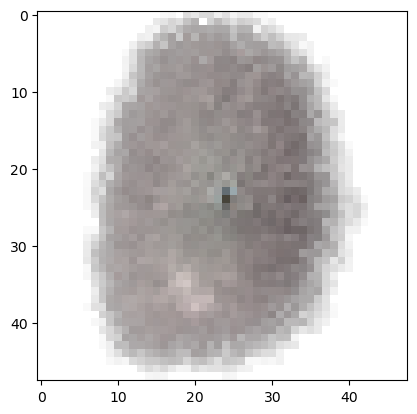

In [12]:
generate_animation(history[-1])
Video(filename="dynamic_images.mp4")

#### Phase 3

In [13]:
new_params  = {'min-steps': 64,
               'max-steps': 400}
HYPERPARAMS.update(new_params)

In [14]:
"""config = optimizer.get_config()
config["learning_rate"] = 1e-3
config["decay"] = 0.9985
optimizer = optimizer.from_config(config, custom_objects=None)
"""

'config = optimizer.get_config()\nconfig["learning_rate"] = 1e-3\nconfig["decay"] = 0.9985\noptimizer = optimizer.from_config(config, custom_objects=None)\n'

In [15]:
from tqdm import tqdm, trange
from collections import defaultdict

EPOCHS = 5001
SAMPLE_EVERY = 100

with trange(EPOCHS) as pbar:
    for epoch in pbar:
        grid = np.zeros((HYPERPARAMS['map_height'], HYPERPARAMS['map_width'], HYPERPARAMS['cell_vars']))
        grid[HYPERPARAMS['map_height']//2][HYPERPARAMS['map_width']//2] += 1 # Alive cell in the middle of the image
        grid = tf.convert_to_tensor(grid, dtype=tf.float32)

        if epoch % SAMPLE_EVERY == 0: history.append([grid[:, :, :3].numpy()])
        n_backprop_steps = random.randint(HYPERPARAMS['min-backprop-steps'],HYPERPARAMS['max-backprop-steps'])
        n_steps = random.randint(HYPERPARAMS['min-steps'], HYPERPARAMS['max-steps'])
        for ep in range(max(0, n_steps - n_backprop_steps)):
            grid += update_grid(grid)
            grid = tf.clip_by_value(grid, 0, 1)
            if epoch % SAMPLE_EVERY == 0: history[-1].append(grid[:, :, :4].numpy())
        with tf.GradientTape() as grad:
            grad.watch(grid); grad.watch(update_model.trainable_variables)
            for ep in range(n_backprop_steps):
                update_batch = update_grid(grid)
                grid = grid + update_batch
                grid = tf.clip_by_value(grid, 0, 1)
                if epoch % SAMPLE_EVERY == 0: history[-1].append(grid[:, :, :4].numpy())

            # dGdP = [tf.reduce_sum(tf.stack(grads_per_step[key]), axis=1) for key in grads_per_step]
            grad.watch(cropped)
            L = loss(grid[:, :, :4], cropped)
        dLdP = grad.gradient(L, update_model.trainable_variables)
        """
            with tf.GradientTape() as grad:
                grad.watch(grid); grad.watch(cropped)
                L = loss(grid[:,:,:3], cropped)
            dLdG = grad.gradient(L, grid)
        """
        optimizer.apply_gradients(zip(dLdP, update_model.trainable_weights))
        pbar.set_description("Loss: {0:.5f}".format(L.numpy()), refresh = True)

Loss: 0.07178:  30%|████████████████▏                                     | 1499/5001 [23:35<52:02,  1.12it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [21]:
from tqdm import tqdm, trange
from collections import defaultdict

EPOCHS = 3001
SAMPLE_EVERY = 100

with trange(EPOCHS) as pbar:
    for epoch in pbar:
        grid = np.zeros((HYPERPARAMS['map_height'], HYPERPARAMS['map_width'], HYPERPARAMS['cell_vars']))
        grid[HYPERPARAMS['map_height']//2][HYPERPARAMS['map_width']//2] += 1 # Alive cell in the middle of the image
        grid = tf.convert_to_tensor(grid, dtype=tf.float32)

        if epoch % SAMPLE_EVERY == 0: history.append([grid[:, :, :3].numpy()])
        n_backprop_steps = random.randint(HYPERPARAMS['min-backprop-steps'],HYPERPARAMS['max-backprop-steps'])
        n_steps = random.randint(HYPERPARAMS['min-steps'], HYPERPARAMS['max-steps'])
        for ep in range(max(0, n_steps - n_backprop_steps)):
            grid += update_grid(grid)
            grid = tf.clip_by_value(grid, 0, 1)
            if epoch % SAMPLE_EVERY == 0: history[-1].append(grid[:, :, :4].numpy())
        with tf.GradientTape() as grad:
            grad.watch(grid); grad.watch(update_model.trainable_variables)
            for ep in range(n_backprop_steps):
                update_batch = update_grid(grid)
                grid = grid + update_batch
                grid = tf.clip_by_value(grid, 0, 1)
                if epoch % SAMPLE_EVERY == 0: history[-1].append(grid[:, :, :4].numpy())

            # dGdP = [tf.reduce_sum(tf.stack(grads_per_step[key]), axis=1) for key in grads_per_step]
            grad.watch(cropped)
            L = loss(grid[:, :, :4], cropped)
        dLdP = grad.gradient(L, update_model.trainable_variables)
        """
            with tf.GradientTape() as grad:
                grad.watch(grid); grad.watch(cropped)
                L = loss(grid[:,:,:3], cropped)
            dLdG = grad.gradient(L, grid)
        """
        optimizer.apply_gradients(zip(dLdP, update_model.trainable_weights))
        pbar.set_description("Loss: {0:.5f}".format(L.numpy()), refresh = True)

Loss: 0.37029:  50%|██████████████████████████▉                           | 1499/3001 [25:22<26:27,  1.06s/it]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
update_model.save('./weights/phase3_run3')

In [ ]:
generate_animation(history[-1])
Video(filename="dynamic_images.mp4")